# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 kafuchino0410@gmail.com


# Readme


這份作業的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/file/d/1e4CaQ5VUF3F04XRDGXrnRQGogo89TiF8/view?usp=sharing)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

In [1]:
# # Download dataset
# !gdown --id '1e4CaQ5VUF3F04XRDGXrnRQGogo89TiF8' --output real_or_drawing.zip
# # Unzip the files
# !unzip real_or_drawing.zip

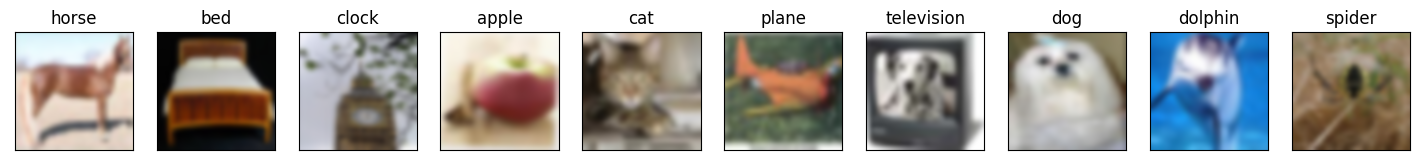

In [2]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  # fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  fig = plt.imshow(img, interpolation='bicubic', cmap=cmap)
  # do not show the axis in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'./real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

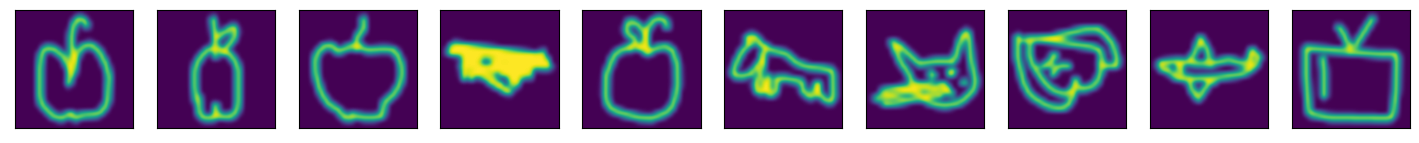

In [3]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'./real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

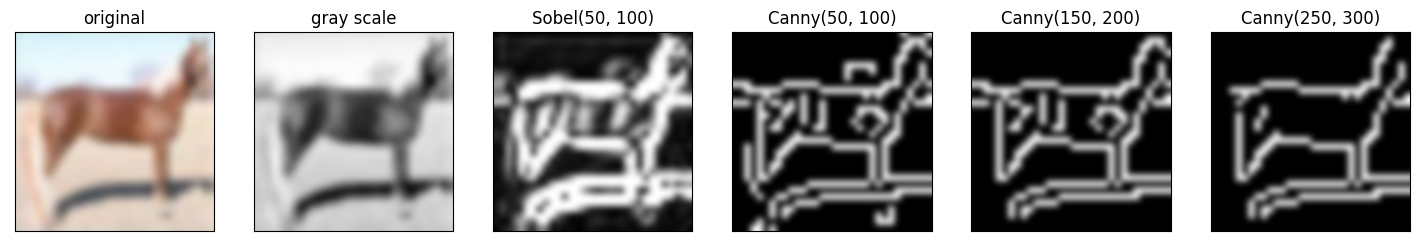

In [4]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'./real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 6, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 6, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

Sobel_X = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
Sobel_Y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)
# Sobel = Sobel_X + Sobel_Y
Sobel = cv2.convertScaleAbs(Sobel_X + Sobel_Y)
plt.subplot(1, 6, 3)
no_axis_show(Sobel, title='Sobel(50, 100)', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 6, 4)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 6, 5)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 6, 6)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。
<!-- 
#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。 -->


In [5]:
from tqdm import tqdm
from time import time
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from collections import defaultdict
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset, Subset, Dataset
import matplotlib.pyplot as plt
import cv2
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_transform_2 = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    # transforms.Lambda(lambda x: cv2.convertScaleAbs(  cv2.Sobel(np.array(x), cv2.CV_64F, 1, 0) + cv2.Sobel(np.array(x), cv2.CV_64F, 0, 1)  )),
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 150, 400)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_transform_3 = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    # transforms.Lambda(lambda x: cv2.convertScaleAbs(  cv2.Sobel(np.array(x), cv2.CV_64F, 1, 0) + cv2.Sobel(np.array(x), cv2.CV_64F, 0, 1)  )),
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 100, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_transform_4 = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    # transforms.Lambda(lambda x: cv2.convertScaleAbs(  cv2.Sobel(np.array(x), cv2.CV_64F, 1, 0) + cv2.Sobel(np.array(x), cv2.CV_64F, 0, 1)  )),
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 50, 150)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

MSDA_source_domain = []
MSDA_source_dataloader_list = []

MSDA_source_dataset_1 = ImageFolder('./real_or_drawing/train_data', transform=source_transform)
MSDA_source_domain.append(MSDA_source_dataset_1)
MSDA_source_dataset_2 = ImageFolder('./real_or_drawing/train_data', transform=source_transform_2)
MSDA_source_domain.append(MSDA_source_dataset_2)
MSDA_source_dataset_3 = ImageFolder('./real_or_drawing/train_data', transform=source_transform_3)
MSDA_source_domain.append(MSDA_source_dataset_3)
MSDA_source_dataset_4 = ImageFolder('./real_or_drawing/train_data', transform=source_transform_4)
MSDA_source_domain.append(MSDA_source_dataset_4)
# print(source_domain)


MSDA_target_dataset = ImageFolder('./real_or_drawing/test_data', transform=target_transform)

# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [6]:
class GradReverse(Function):
    def __init__(self , lambd):
        self.lambd = lambd
        return

    def forward(self , x):
        return x.view_as(x)

    def backward(self , grad_output):
        return -self.lambd * grad_output

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class Classifier(nn.Module):
    def __init__(self):
        
        super(Classifier , self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c
    # def set_lambda(self , lambd):
    # 	self.lambd = lambd
    # 	return

    # def forward(self , x , reverse = False):
    # 	if (reverse):
    # 		x = grad_reverse(x , self.lambd)
    # 	x = F.relu(self.bn1(self.fc1(x)))
    # 	x = self.fc2(x)
    # 	return x


# Pre-processing

這裡我們選用Adam來當Optimizer。

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
min_ = float('inf')
BATCH_SIZE = 32

class_criterion = nn.CrossEntropyLoss()
L1_loss = nn.L1Loss()
L2_loss = nn.MSELoss()
def discrepancy(output_1 , output_2):
	return torch.mean(torch.abs(F.softmax(output_1 , dim = 1) - F.softmax(output_2 , dim = 1)))
	# return L1_loss(F.softmax(output_1 , dim = 1), F.softmax(output_2 , dim = 1))


MSDA_generator = Generator().cuda()
MSDA_classifier_1 = Classifier().cuda()
MSDA_classifier_2 = Classifier().cuda()

# MSDA_generator.load_state_dict(torch.load("./MSDAmodel/MSDA_generator.pt"))
# MSDA_classifier_1.load_state_dict(torch.load('./MSDAmodel/MSDA_classifier_1.pt'))
# MSDA_classifier_2.load_state_dict(torch.load('./MSDAmodel/MSDA_classifier_2.pt'))

optimizer_MSDA_generator = optim.Adam(MSDA_generator.parameters())
optimizer_MSDA_classifier_1 = optim.Adam(MSDA_classifier_1.parameters())
optimizer_MSDA_classifier_2 = optim.Adam(MSDA_classifier_2.parameters())

for source in MSDA_source_domain:
	# print(source)
	source_dataset_loader = DataLoader(source, batch_size = 32, shuffle=True)
	if len(source_dataset_loader) < min_:
			min_ = len(source_dataset_loader)
	MSDA_source_dataloader_list.append(source_dataset_loader)

MSDA_target_dataloader = DataLoader(MSDA_target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(MSDA_target_dataset, batch_size=128, shuffle=False)

if len(MSDA_target_dataloader) < min_:
		min_ = len(MSDA_target_dataloader)

## Pseudo Label

In [8]:
class PseudoDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, id):
        return self.x[id][0], self.y[id]

pseudo_labels_batch_size = 256
def get_pseudo_labels(dataset, threshold=0.9):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=pseudo_labels_batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    MSDA_generator.eval()
    MSDA_classifier_1.eval()
    MSDA_classifier_2.eval()
    
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    idx = []
    labels = []

    # Iterate over the dataset by batches.
    # for batch in tqdm(data_loader):
    for i, batch in enumerate(data_loader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            img = img.cuda()

            feature = MSDA_generator(img)
            y_1 = MSDA_classifier_1(feature)
            prob_1 = softmax(y_1)
            y_2 = MSDA_classifier_2(feature)
            prob_2 = softmax(y_2)
            probs = (prob_1 + prob_2) / 2
        # Obtain the probability distributions by applying softmax on logits.

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.
        for j, x in enumerate(probs):
            if torch.max(x) > threshold:
                idx.append(i * pseudo_labels_batch_size + j)
                labels.append(int(torch.argmax(x)))

    # Turn off the eval mode.
    MSDA_generator.train()
    MSDA_classifier_1.train()
    MSDA_classifier_2.train()
    
    print ("\nNew data: {:5d}\n".format(len(idx)))
    dataset = PseudoDataset(Subset(dataset, idx), labels)
    return dataset




## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

## Function Define

In [9]:
def euclidean(x1,x2):
	# print( ((x1-x2)**2).sum().sqrt() )
	return ((x1-x2)**2).sum().sqrt()

def k_moment(output_s1, output_s2, output_s3, output_s4, output_t, k):
	output_s1 = (output_s1**k).mean(0)
	output_s2 = (output_s2**k).mean(0)
	output_s3 = (output_s3**k).mean(0)
	output_t = (output_t**k).mean(0)
	return  euclidean(output_s1, output_t) + euclidean(output_s2, output_t) + euclidean(output_s3, output_t)+ \
		euclidean(output_s1, output_s2) + euclidean(output_s2, output_s3) + euclidean(output_s3, output_s1) +\
		euclidean(output_s4, output_s1) + euclidean(output_s4, output_s2) + euclidean(output_s4, output_s2) + \
		euclidean(output_s4, output_t)
# def k_moment(output_s1, output_s2, output_t, k):
# 	output_s1 = (output_s1**k).mean(0)
# 	output_s2 = (output_s2**k).mean(0)
# 	output_t = (output_t**k).mean(0)
# 	# print("output_s1 = ", end="")
# 	# print(output_s1.shape[0], end="")
# 	# print(" output_s2 = ", end="")
# 	# print(output_s2.shape[0], end="")
# 	# print(" output_t = ", end="")
# 	# print(output_t.shape[0])
# 	return  euclidean(output_s1, output_t) + euclidean(output_s2, output_t) + euclidean(output_s1, output_s2)

def msda_regulizer(output_s1, output_s2, output_s3, output_s4, output_t, belta_moment):
	# print('s1:{}, s2:{}, s3:{}, s4:{}'.format(output_s1.shape, output_s2.shape, output_s3.shape, output_t.shape))
	s1_mean = output_s1.mean(0)
	s2_mean = output_s2.mean(0)
	s3_mean = output_s3.mean(0)
	t_mean = output_t.mean(0)
	output_s1 = output_s1 - s1_mean
	output_s2 = output_s2 - s2_mean
	output_s3 = output_s3 - s3_mean
	output_t = output_t - t_mean
	moment1 = euclidean(output_s1, output_t) + euclidean(output_s2, output_t) + euclidean(output_s3, output_t)+\
		euclidean(output_s1, output_s2) + euclidean(output_s2, output_s3) + euclidean(output_s3, output_s1) +\
		euclidean(output_s4, output_s1) + euclidean(output_s4, output_s2) + euclidean(output_s4, output_s2) + \
		euclidean(output_s4, output_t)
	reg_info = moment1
	#print(reg_info)
	for i in range(belta_moment-1):
		reg_info += k_moment(output_s1,output_s2,output_s3, output_s4, output_t,i+2)
	
	return reg_info/6

# def msda_regulizer(output_s1, output_s2, output_t, belta_moment):
# 	s1_mean = output_s1.mean(0)
# 	s2_mean = output_s2.mean(0)
# 	t_mean = output_t.mean(0)
# 	output_s1 = output_s1 - s1_mean
# 	output_s2 = output_s2 - s2_mean
# 	output_t = output_t - t_mean
# 	moment1 = euclidean(output_s1, output_t) + euclidean(output_s2, output_t) + euclidean(output_s1, output_s2)
# 	reg_info = moment1
# 	#print(reg_info)
# 	for i in range(belta_moment-1):
# 		reg_info += k_moment(output_s1,output_s2, output_t, i+2)
# 	return reg_info/6

def feat_all_domain(img_s1, img_s2, img_s3, img_s4, img_t):
    return MSDA_generator(img_s1), MSDA_generator(img_s2), MSDA_generator(img_s3), MSDA_generator(img_s4), MSDA_generator(img_t)
	
# def feat_all_domain(img_s1, img_s2, img_t):
#     return MSDA_generator(img_s1), MSDA_generator(img_s2), MSDA_generator(img_t)

def C1_all_domain(feat1, feat2, feat3, feat4, feat_t):
    return MSDA_classifier_1(feat1), MSDA_classifier_1(feat2), MSDA_classifier_1(feat3), MSDA_classifier_1(feat4), MSDA_classifier_1(feat_t)

def C2_all_domain(feat1, feat2, feat3, feat4, feat_t):
    return MSDA_classifier_2(feat1), MSDA_classifier_2(feat2), MSDA_classifier_2(feat3), MSDA_classifier_2(feat4), MSDA_classifier_2(feat_t) 

def softmax_loss_all_domain(output1, output2, output3, output4, label_s1, label_s2, label_s3, label_s4):
    return class_criterion(output1, label_s1), class_criterion(output2, label_s2), class_criterion(output3, label_s3), class_criterion(output4,label_s4)

# def softmax_loss_all_domain(output1, output2, label_s1, label_s2):
#     return class_criterion(output1, label_s1), class_criterion(output2, label_s2)


def loss_all_domain(img_s1, img_s2, img_s3, img_s4, img_t, label_s1, label_s2, label_s3, label_s4):
	feat_s1, feat_s2, feat_s3, feat_s4, feat_t = feat_all_domain(img_s1, img_s2, img_s3, img_s4, img_t)
	output_s1_c1, output_s2_c1, output_s3_c1, output_s4_c1, output_t_c1 = \
		C1_all_domain(feat_s1, feat_s2, feat_s3, feat_s4, feat_t)
	output_s1_c2, output_s2_c2, output_s3_c2, output_s4_c2, output_t_c2 = \
		C2_all_domain(feat_s1,feat_s2, feat_s3, feat_s4, feat_t)
	loss_msda =  0.0005* msda_regulizer(feat_s1, feat_s2, feat_s3, feat_s4, feat_t, 5)
	loss_s1_c1, loss_s2_c1,loss_s3_c1,loss_s4_c1 =\
		softmax_loss_all_domain(output_s1_c1, output_s2_c1, output_s3_c1,output_s4_c1, label_s1, label_s2, label_s3,label_s4)
	loss_s1_c2, loss_s2_c2,loss_s3_c2,loss_s4_c2 =\
		softmax_loss_all_domain(output_s1_c2, output_s2_c2, output_s3_c2,output_s4_c2, label_s1, label_s2, label_s3,label_s4)
	return  loss_s1_c1, loss_s2_c1,loss_s3_c1,loss_s4_c1, loss_s1_c2, loss_s2_c2,loss_s3_c2,loss_s4_c2, loss_msda
# def loss_all_domain(img_s1, img_s2, img_t, label_s1, label_s2):
#         feat_s1, feat_s2, feat_t = feat_all_domain(img_s1, img_s2, img_t)
#         output_s1_c1, output_s2_c1, output_t_c1 = C1_all_domain(feat_s1, feat_s2, feat_t)
#         output_s1_c2, output_s2_c2, output_t_c2 = C2_all_domain(feat_s1,feat_s2, feat_t)
#         loss_msda =  0.0005* msda_regulizer(feat_s1, feat_s2, feat_t, 5)
#         loss_s1_c1, loss_s2_c1 = softmax_loss_all_domain(output_s1_c1, output_s2_c1, label_s1, label_s2)
#         loss_s1_c2, loss_s2_c2 = softmax_loss_all_domain(output_s1_c2, output_s2_c2, label_s1, label_s2)        
#         return  loss_s1_c1, loss_s2_c1, loss_s1_c2, loss_s2_c2, loss_msda

## MSDA Train Function

In [10]:
def MSDA_train_epoch(epoch, num_epochs, source_dataloader_list, target_dataloader):
    '''
    Args:
    source_dataloader: source data的dataloader
    target_dataloader: target data的dataloader
    lamb: control the balance of domain adaptatoin and classification.
    '''
    start = time()
    running_Step1_loss, running_Step2_loss, running_Step3_loss = 0.0, 0.0, 0.0
    total_hit1, total_hit2, total_num = 0.0, 0.0, 0.0

    source_dataloader_lengths = [len(dataloader) for dataloader in source_dataloader_list]
    target_dataloader_length = len(target_dataloader)
    max_batch_count = min(min(source_dataloader_lengths), target_dataloader_length)

    last_batch_index = max_batch_count - 1

    for batch_index, (src_batch, tar_batch) in enumerate(zip(zip(*source_dataloader_list), target_dataloader)):
        if batch_index != last_batch_index:
            # Step 1
            source_data_1 = 0
            source_label_1 = 0
            source_data_2 = 0
            source_label_2 = 0
            source_data_3 = 0
            source_label_3 = 0
            source_data_4 = 0
            source_label_4 = 0
            # source_data_1, source_label_1 = src_batch[0]
            # source_data_1 = source_data_1.cuda()
            # source_label_1 = source_label_1.cuda()
            # source_data_2, source_label_2 = src_batch[1]
            # source_data_2 = source_data_2.cuda()
            # source_label_2 = source_label_2.cuda()
            target_data, _ = tar_batch
            target_data = target_data.cuda()
            for index, batch in enumerate(src_batch):
                if index == 0:
                    source_data_1, source_label_1 = batch
                    source_data_1 = source_data_1.cuda()
                    source_label_1 = source_label_1.cuda()
                    continue
                elif index == 1:
                    source_data_2, source_label_2 = batch
                    source_data_2 = source_data_2.cuda()
                    source_label_2 = source_label_2.cuda()
                elif index == 2:
                    source_data_3, source_label_3 = batch
                    source_data_3 = source_data_3.cuda()
                    source_label_3 = source_label_3.cuda()
                elif index == 3:
                    source_data_4, source_label_4 = batch
                    source_data_4 = source_data_4.cuda()
                    source_label_4 = source_label_4.cuda()

            optimizer_MSDA_generator.zero_grad()
            optimizer_MSDA_classifier_1.zero_grad()
            optimizer_MSDA_classifier_2.zero_grad()

            loss_s1_c1, loss_s2_c1, loss_s3_c1, loss_s4_c1, loss_s1_c2, loss_s2_c2, loss_s3_c2, loss_s4_c2, loss_msda = loss_all_domain(
                source_data_1, source_data_2, source_data_3, source_data_4, target_data, source_label_1, source_label_2, source_label_3, source_label_4)

            loss_s_c1 = loss_s1_c1 + loss_s2_c1 + loss_s3_c1 + loss_s4_c1
            loss_s_c2 = loss_s1_c2 + loss_s2_c2 + loss_s3_c2 + loss_s4_c2
            loss = loss_s_c1 + loss_s_c2 + loss_msda
            running_Step1_loss += loss.item()

            loss.backward()

            optimizer_MSDA_generator.step()
            optimizer_MSDA_classifier_1.step()
            optimizer_MSDA_classifier_2.step()

            optimizer_MSDA_generator.zero_grad()
            optimizer_MSDA_classifier_1.zero_grad()
            optimizer_MSDA_classifier_2.zero_grad()

            # Step 2
            loss_s1_c1, loss_s2_c1, loss_s3_c1, loss_s4_c1, loss_s1_c2, loss_s2_c2, loss_s3_c2, loss_s4_c2, loss_msda = loss_all_domain(
                source_data_1, source_data_2, source_data_3, source_data_4, target_data, source_label_1, source_label_2, source_label_3, source_label_4)
            
            target_feature = MSDA_generator(target_data)
            output_target_1 = MSDA_classifier_1(target_feature)
            output_target_2 = MSDA_classifier_2(target_feature)
            
            loss_s_c1 = loss_s1_c1 + loss_s2_c1 + loss_s3_c1 + loss_s4_c1
            loss_s_c2 = loss_s1_c2 + loss_s2_c2 + loss_s3_c2 + loss_s4_c2
            # loss_s = loss_s1_c1 + loss_s2_c2 + loss_msda
            loss_s = loss_s_c1 + loss_s_c2 + loss_msda
            loss_discrepancy = discrepancy(output_target_1, output_target_2)
            loss = loss_s - loss_discrepancy
            running_Step2_loss += loss.item()

            loss.backward()

            optimizer_MSDA_classifier_1.step()
            optimizer_MSDA_classifier_2.step()

            optimizer_MSDA_generator.zero_grad()
            optimizer_MSDA_classifier_1.zero_grad()
            optimizer_MSDA_classifier_2.zero_grad()

            # Step 3
            for i in range(4):
                target_feature = MSDA_generator(target_data)
                output_target_1 = MSDA_classifier_1(target_feature)
                output_target_2 = MSDA_classifier_2(target_feature)
                loss_discrepancy = discrepancy(output_target_1, output_target_2)
                if i == 3:
                    running_Step3_loss += loss_discrepancy.item()
                loss_discrepancy.backward()
                optimizer_MSDA_generator.step()
                optimizer_MSDA_generator.zero_grad()
                optimizer_MSDA_classifier_1.zero_grad()
                optimizer_MSDA_classifier_2.zero_grad()

        feature = MSDA_generator(source_data_1)
        y_1 = MSDA_classifier_1(feature)
        y_2 = MSDA_classifier_2(feature)
        total_hit1 += torch.sum(torch.argmax(y_1, dim=1) == source_label_1).item()
        total_hit2 += torch.sum(torch.argmax(y_2, dim=1) == source_label_1).item()
        total_num += source_data_1.shape[0]

        feature = MSDA_generator(source_data_2)
        y_1 = MSDA_classifier_1(feature)
        y_2 = MSDA_classifier_2(feature)
        total_hit1 += torch.sum(torch.argmax(y_1, dim=1) == source_label_2).item()
        total_hit2 += torch.sum(torch.argmax(y_2, dim=1) == source_label_2).item()
        total_num += source_data_2.shape[0]

        if (batch_index < min(len(source_dataloader_list[0]), len(source_dataloader_list[1]) , len(target_dataloader)) - 1):
            m = int(50 * (batch_index + 1) / min(len(source_dataloader_list[0]), len(source_dataloader_list[1]), len(target_dataloader)))
            bar = m * '=' + '>' + (49 - m) * ' '
            print('epoch {}/{} [{}]'.format(epoch + 1 , num_epochs , bar) , end = '\r')
        else:
            bar = 50 * '='
            end = time()
            print('epoch {}/{} [{}] ({}s)'.format(epoch+ 1 , num_epochs , bar , int(end - start)))

    return running_Step1_loss / (batch_index+1) , running_Step2_loss / (batch_index+1), running_Step3_loss / (batch_index+1), total_hit1 / total_num, total_hit2 / total_num

# Start Training

In [11]:
# training
num_epochs = 2000


MSDA_generator.train()
MSDA_classifier_1.train()
MSDA_classifier_2.train()

for epoch in range(num_epochs):
    # You should chooose lamnda cleverly.
    print('epoch {:3d}: '.format(epoch+1), end="")
    train_Total_loss, train_Step2_loss, train_Discrepency_loss, train_C1_acc, train_C2_acc = MSDA_train_epoch(epoch, num_epochs, MSDA_source_dataloader_list, MSDA_target_dataloader)

    torch.save(MSDA_generator.state_dict() , './MSDAmodel/MSDA_generator.pt')
    torch.save(MSDA_classifier_1.state_dict() , './MSDAmodel/MSDA_classifier_1.pt')
    torch.save(MSDA_classifier_2.state_dict() , './MSDAmodel/MSDA_classifier_2.pt')

    # torch.save(MSDA_generator.state_dict() , './MSDAmodel/MSDA_generator-v2.pt')
    # torch.save(MSDA_classifier_1.state_dict() , './MSDAmodel/MSDA_classifier_1-v2.pt')
    # torch.save(MSDA_classifier_2.state_dict() , './MSDAmodel/MSDA_classifier_2-v2.pt')
    print('epoch {:>3d}: train_Total_loss: {:6.4f}, train_Step2_loss: {:6.4f}, train_Discrepency_loss: {:6.4f}, F1_acc {:6.4f}, F2_acc {:6.4f}'.format(epoch+1, train_Total_loss, train_Step2_loss, train_Discrepency_loss, train_C1_acc, train_C2_acc))

    if (epoch+1) != 0 and (epoch+1) % 100 == 0 :
        result = []

        MSDA_generator.eval()
        MSDA_classifier_1.eval()
        MSDA_classifier_2.eval()

        with torch.no_grad():
            for i, (test_data, _) in enumerate(test_dataloader):
                test_data = test_data.cuda()

                feature = MSDA_generator(test_data)
                y_1 = MSDA_classifier_1(feature)
                y_2 = MSDA_classifier_2(feature)
                y = (y_1 + y_2) 
                
                answer = torch.argmax(y, dim = 1).cpu().detach().numpy()
                result.append(answer)

        import pandas as pd
        result = np.concatenate(result)

        # Generate your submission
        df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
        df.to_csv('./MSDA_Predict/MSDA_submission-' + str(epoch+1) + '.csv',index=False)


        torch.save(MSDA_generator.state_dict() , './MSDAmodel/MSDA_generator-' + str(epoch+1) + '.pt')
        torch.save(MSDA_classifier_1.state_dict() , './MSDAmodel/MSDA_classifier_1-' + str(epoch+1) + '.pt')
        torch.save(MSDA_classifier_2.state_dict() , './MSDAmodel/MSDA_classifier_2-' + str(epoch+1) + '.pt')
        
        MSDA_generator.train()
        MSDA_classifier_1.train()
        MSDA_classifier_2.train()

epoch 1/2000 [==================================================] (37s)    ]
epoch   1: train_Total_loss: 13.7068, train_Step2_loss: 12.9099, train_Discrepency_loss: 0.0092, F1_acc 0.4790, F2_acc 0.4769
epoch 2/2000 [==================================================] (34s)    ]
epoch   2: train_Total_loss: 11.3734, train_Step2_loss: 10.6885, train_Discrepency_loss: 0.0057, F1_acc 0.5987, F2_acc 0.5990
epoch 3/2000 [==================================================] (34s)    ]
epoch   3: train_Total_loss: 10.5266, train_Step2_loss: 9.8389, train_Discrepency_loss: 0.0047, F1_acc 0.6420, F2_acc 0.6407
epoch 4/2000 [==================================================] (34s)    ]
epoch   4: train_Total_loss: 9.8516, train_Step2_loss: 9.1282, train_Discrepency_loss: 0.0045, F1_acc 0.6849, F2_acc 0.6839
epoch 5/2000 [==================================================] (34s)    ]
epoch   5: train_Total_loss: 9.3376, train_Step2_loss: 8.5448, train_Discrepency_loss: 0.0047, F1_acc 0.7109, F2_a

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [ ]:
result = []

MSDA_generator = Generator().cuda()
MSDA_classifier_1 = Classifier().cuda()
MSDA_classifier_2 = Classifier().cuda()

MSDA_generator.load_state_dict(torch.load("./MSDAmodel/MSDA_generator.pt"))
MSDA_classifier_1.load_state_dict(torch.load('./MSDAmodel/MSDA_classifier_1.pt'))
MSDA_classifier_2.load_state_dict(torch.load('./MSDAmodel/MSDA_classifier_2.pt'))

MSDA_generator.eval()
MSDA_classifier_1.eval()
MSDA_classifier_2.eval()


with torch.no_grad():
    for i, (test_data, _) in enumerate(test_dataloader):
        test_data = test_data.cuda()

        feature = MSDA_generator(test_data)
        y_1 = MSDA_classifier_1(feature)
        y_2 = MSDA_classifier_2(feature)
        y = (y_1 + y_2) 
               
        answer = torch.argmax(y, dim = 1).cpu().detach().numpy()
        result.append(answer)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('MSDA-1_submission.csv',index=False)
# df.to_csv('MSDA_submission.csv',index=False)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Special Thanks
下面是原本台大助教提供的參考作業。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
